In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import math

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from keras.models import load_model
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("VCB3.csv")
df

,Date,Price,Open,High,Low,Vol.,Change %
0,11/30/2015,23.115,23.815,23.869,23.115,1.68M,-3.16%
1,12/1/2015,22.684,23.115,23.384,22.630,1.52M,-1.86%
2,12/2/2015,22.738,22.684,23.007,22.630,2.99M,0.24%
3,12/3/2015,22.953,22.630,23.223,22.630,1.70M,0.95%
4,12/4/2015,22.792,23.115,23.115,22.684,833.53K,-0.70%
...,...,...,...,...,...,...,...
1747,11/24/2022,73.000,73.500,74.000,72.500,1.08M,-0.68%
1748,11/25/2022,73.100,73.100,73.600,72.800,1.68M,0.14%
1749,11/28/2022,76.700,74.500,77.000,73.800,1.34M,4.92%
1750,11/29/2022,79.800,76.000,79.800,76.000,1.71M,4.04%


Text(0, 0.5, 'Prices (VND)')

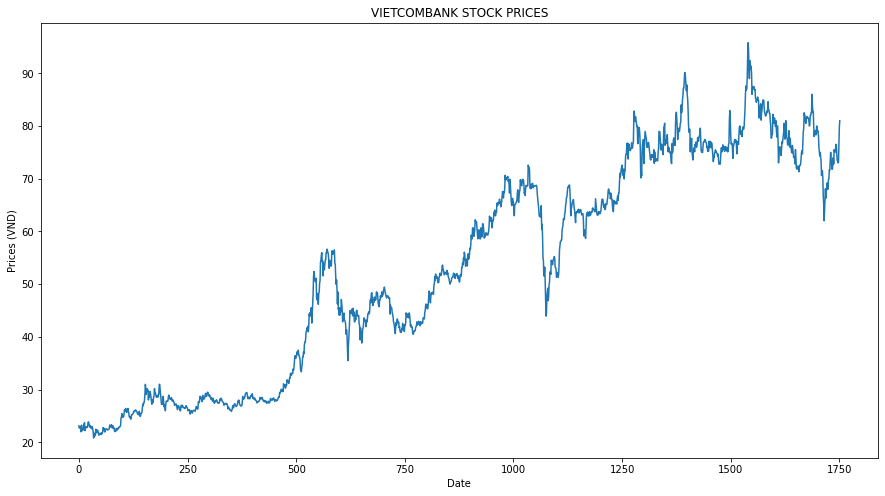

In [4]:
plt.figure(figsize=(15, 8))
plt.title('VIETCOMBANK STOCK PRICES')
plt.plot(df['Price'])
plt.xlabel('Date')
plt.ylabel('Prices (VND)')

In [22]:
p = df['Price']
v = p.values
train_data_len = math.ceil(len(v)* 0.8)

In [23]:
sc = MinMaxScaler(feature_range=(0,1))
scaled_data = sc.fit_transform(v.reshape(-1,1))

train_data = scaled_data[0: train_data_len, :]

In [24]:
X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [25]:
test_data = scaled_data[train_data_len-60: , : ]
X_test = []
y_test = v[train_data_len:]

for i in range(60, len(test_data)):
  X_test.append(test_data[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [26]:
model = Sequential()
model.add(layers.LSTM(units = 64,input_shape=(X_train.shape[1], 1),return_sequences=True))
model.add(Dropout(0.5))
model.add(layers.LSTM(units = 64, return_sequences=True))
model.add(Dropout(0.5))
model.add(layers.LSTM(units = 64, return_sequences=False))
model.add(Dropout(0.5))
model.add(layers.Dense(25))
model.add(layers.Dense(1))

In [27]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size= 32, epochs=10)

Epoch 1/10
42/42 [==============================] - 10s 112ms/step - loss: 0.0185
Epoch 2/10
42/42 [==============================] - 5s 127ms/step - loss: 0.0057
Epoch 3/10
42/42 [==============================] - 4s 103ms/step - loss: 0.0044
Epoch 4/10
42/42 [==============================] - 4s 102ms/step - loss: 0.0044
Epoch 5/10
42/42 [==============================] - 4s 104ms/step - loss: 0.0035
Epoch 6/10
42/42 [==============================] - 4s 102ms/step - loss: 0.0038
Epoch 7/10
42/42 [==============================] - 4s 101ms/step - loss: 0.0030
Epoch 8/10
42/42 [==============================] - 4s 102ms/step - loss: 0.0028
Epoch 9/10
42/42 [==============================] - 4s 101ms/step - loss: 0.0027
Epoch 10/10
42/42 [==============================] - 4s 103ms/step - loss: 0.0027


In [28]:
pred = model.predict(X_test)
pred = sc.inverse_transform(pred)

11/11 [==============================] - 2s 29ms/step


In [29]:
train_data.shape

(1402, 1)

In [30]:
# Create an input array using the last 10 days of the scaled test data
x_input = train_data[1392:].reshape(1, -1)

print(x_input.shape)

(1, 10)


In [31]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

print(temp_input)

[0.884989733607104, 0.8994426815284926, 0.92421535425722, 0.92421535425722, 0.908722434068425, 0.8953094584144423, 0.8787898989360285, 0.8932428468574174, 0.86847017412869, 0.8560838377643265]


In [32]:
# Initialize variables
lst_output = []
n_steps = 10
i = 0

while(i < 30):
    if(len(temp_input) > 10):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)

        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps,1))

        yhat = model.predict(x_input, verbose=0)

        temp_input.extend(yhat[0].tolist())

        lst_output.extend(yhat.tolist())
        i += 1

In [33]:
y_pred_future = sc.inverse_transform(lst_output)

print(y_pred_future)

[[78.34880563]
 [78.06636149]
 [77.49233111]
 [76.6135713 ]
 [75.59533737]
 [74.54485796]
 [73.47627316]
 [72.42313829]
 [71.25880948]
 [70.18756475]
 [69.14831962]
 [68.48778122]
 [67.77104903]
 [67.03200922]
 [66.30160634]
 [65.59576869]
 [64.92073256]
 [64.28002962]
 [63.67391915]
 [63.10984003]
 [62.581319  ]
 [62.08644271]
 [61.60230001]
 [61.13591848]
 [60.69098179]
 [60.2683572 ]
 [59.86751272]
 [59.48734416]
 [59.12649249]
 [58.78361657]]


In [34]:
import datetime as dt

# Convert the 'date' column in the dataframe to a list of strings
datelist_train = df['Date'].astype(str).tolist()

# Parse the date strings using strptime(), using the correct format string
datelist_train = [dt.datetime.strptime(date, '%m/%d/%Y').date() for date in datelist_train]

# Generate a list of future dates, starting from the last date in the training data and going for 15 days
datelist_future = pd.date_range(datelist_train[-1], periods=30, freq='1d').tolist()

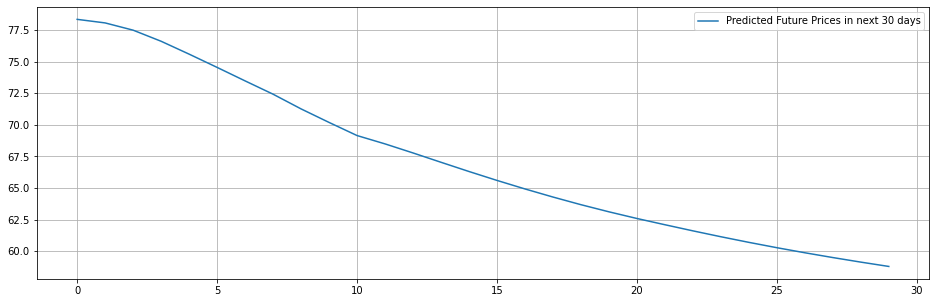

In [35]:
# Set the figure size and create a subplot
plt.figure(figsize=(16,5))

# Plot the actual and predicted prices in the test set, and the predicted future prices
plt.plot(y_pred_future, label='Predicted Future Prices in next 30 days')

# Add a legend and grid
plt.legend()
plt.grid()

In [36]:
pred2 = model.predict(X_train)
pred2 = sc.inverse_transform(pred2)

42/42 [==============================] - 1s 29ms/step


<ipython-input-37-537967364b01>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['Predictions'] = pred


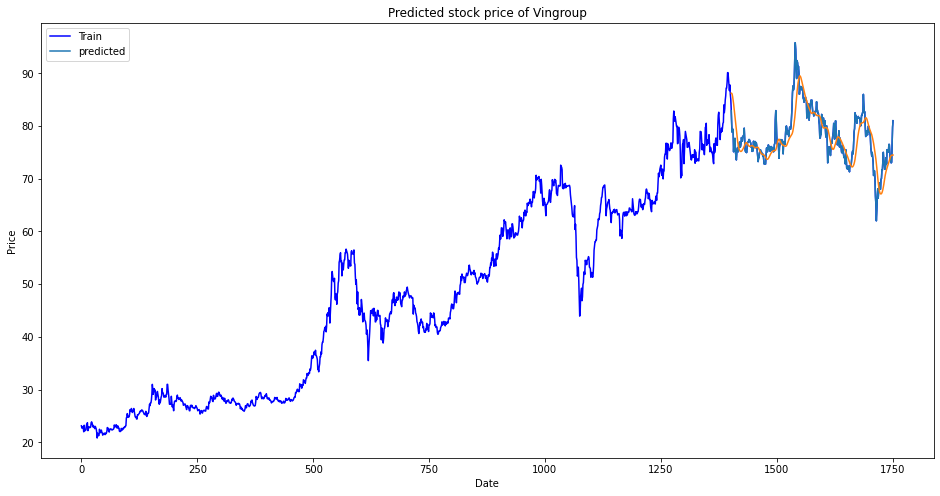

In [37]:
data = df.filter(['Price'])
train = data[:train_data_len]
#real_price = df[train_data_len:]['Price'].values.reshape(-1,1)
#real_price = np.array(real_price)
#real_price = real_price.reshape(real_price.shape[0], 1)
val = data[train_data_len:]
val['Predictions'] = pred
plt.figure(figsize=(16,8))
plt.title('Predicted stock price of Vingroup')
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(df['Price'], color='blue', label='Actual Price')
#plt.plot(pred2, color='red')
plt.plot(val[['Price', 'Predictions']])
plt.legend(['Train', 'predicted'], loc='upper left')
plt.show()

In [38]:
real_data=val['Price']

mape = mean_absolute_percentage_error(real_data, pred)
mse = mean_squared_error(real_data, pred)
rmse = np.sqrt(mse)
print(f"MAPE: {mape * 100:.2f}%")
print(f"RMSE: {rmse:.0f}")

MAPE: 2.93%
RMSE: 3
